In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/CelebA-HQ-img-20000.zip

Streaming output truncated to the last 5000 lines.
  inflating: CelebA-HQ-img-20000/3316.jpg  
  inflating: __MACOSX/CelebA-HQ-img-20000/._3316.jpg  
  inflating: CelebA-HQ-img-20000/4479.jpg  
  inflating: __MACOSX/CelebA-HQ-img-20000/._4479.jpg  
  inflating: CelebA-HQ-img-20000/21792.jpg  
  inflating: __MACOSX/CelebA-HQ-img-20000/._21792.jpg  
  inflating: CelebA-HQ-img-20000/15437.jpg  
  inflating: __MACOSX/CelebA-HQ-img-20000/._15437.jpg  
  inflating: CelebA-HQ-img-20000/8243.jpg  
  inflating: __MACOSX/CelebA-HQ-img-20000/._8243.jpg  
  inflating: CelebA-HQ-img-20000/7170.jpg  
  inflating: __MACOSX/CelebA-HQ-img-20000/._7170.jpg  
  inflating: CelebA-HQ-img-20000/24832.jpg  
  inflating: __MACOSX/CelebA-HQ-img-20000/._24832.jpg  
  inflating: CelebA-HQ-img-20000/12358.jpg  
  inflating: __MACOSX/CelebA-HQ-img-20000/._12358.jpg  
  inflating: CelebA-HQ-img-20000/1501.jpg  
  inflating: __MACOSX/CelebA-HQ-img-20000/._1501.jpg  
  inflating: CelebA-HQ-img-20000/13046.jpg  
  inf

In [ ]:
!unzip /content/drive/MyDrive/CelebA-HQ-mask-20000.zip

Streaming output truncated to the last 5000 lines.
  inflating: CelebA-HQ-mask-20000/13247_hair.png  
  inflating: __MACOSX/CelebA-HQ-mask-20000/._13247_hair.png  
  inflating: CelebA-HQ-mask-20000/14386_hair.png  
  inflating: __MACOSX/CelebA-HQ-mask-20000/._14386_hair.png  
  inflating: CelebA-HQ-mask-20000/14083_hair.png  
  inflating: __MACOSX/CelebA-HQ-mask-20000/._14083_hair.png  
  inflating: CelebA-HQ-mask-20000/04926_hair.png  
  inflating: __MACOSX/CelebA-HQ-mask-20000/._04926_hair.png  
  inflating: CelebA-HQ-mask-20000/01716_hair.png  
  inflating: __MACOSX/CelebA-HQ-mask-20000/._01716_hair.png  
  inflating: CelebA-HQ-mask-20000/25548_hair.png  
  inflating: __MACOSX/CelebA-HQ-mask-20000/._25548_hair.png  
  inflating: CelebA-HQ-mask-20000/13324_hair.png  
  inflating: __MACOSX/CelebA-HQ-mask-20000/._13324_hair.png  
  inflating: CelebA-HQ-mask-20000/22489_hair.png  
  inflating: __MACOSX/CelebA-HQ-mask-20000/._22489_hair.png  
  inflating: CelebA-HQ-mask-20000/06821_hair.

In [ ]:
# Set Paths
IMAGE_DIR = "/content/CelebA-HQ-img-20000"
MASK_DIR = "/content/CelebA-HQ-mask-20000"

# Image and Mask Dimensions
IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_CLASSES = 2  # Number of segmentation classes (e.g., skin, hair, eyes, etc.)

In [ ]:
import re

def extract_number(filename):
  """
  Extracts the number from a filename like "0.jpg".

  Args:
    filename: The filename string.

  Returns:
    The extracted number as an integer, or None if no number is found.
  """
  match = re.search(r"(\d+)", filename)
  if match:
    return int(match.group(1))
  return None

# Example usage
filename = "0.jpg"
number = extract_number(filename)
if number is not None:
    print(f"The number extracted from '{filename}' is: {number}")
else:
    print(f"No number found in '{filename}'")

The number extracted from '0.jpg' is: 0


In [ ]:
# prompt: how to load model from path /content/drive/MyDrive/Computer_Vision/best_model.h5
# loading model 2 - Custom CNN Model
from tensorflow import keras

model = keras.models.load_model('/content/drive/MyDrive/Computer_Vision_h5_model/best_model2_20000.h5')


In [ ]:

def load_data(image_dir, mask_dir, batch_size=32, test_data=False, test_size=0.2, random_state=42):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    # Split into train and test sets if requested
    if test_data:
      _, test_image_files, _, test_mask_files = train_test_split(
          image_files, mask_files, test_size=test_size, random_state=random_state
      )
      image_files = test_image_files
      mask_files = test_mask_files

    num_samples = len(image_files)

    for i in range(0, num_samples, batch_size):
        batch_images, batch_masks = [], []
        for j in range(i, min(i + batch_size, num_samples)):
            img_name = image_files[j]

            # Extract image number and construct mask filename
            filenumber = extract_number(img_name)
            image_number = str(filenumber).zfill(5)
            mask_name = image_number + "_hair.png"

            img_path = os.path.join(image_dir, img_name)
            mask_path = os.path.join(mask_dir, mask_name)

            if not os.path.exists(mask_path):
                print(f"Mask file not found for image: {image_number}")
                continue

            img = cv2.imread(img_path)
            if img is None:
                print(f"Error reading image: {img_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            img = img / 255.0  # Normalize

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Error reading mask: {mask_path}")
                continue
            mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
            mask = (mask / 255 * (NUM_CLASSES - 1)).astype(np.uint8)
            mask = to_categorical(mask, NUM_CLASSES)

            batch_images.append(img)
            batch_masks.append(mask)

        yield np.array(batch_images), np.array(batch_masks)



In [ ]:
# Get test data in batches
test_batch_size = 8 # Set batch size for test data
test_data_generator = load_data(IMAGE_DIR, MASK_DIR, batch_size=test_batch_size,test_data=True)




1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


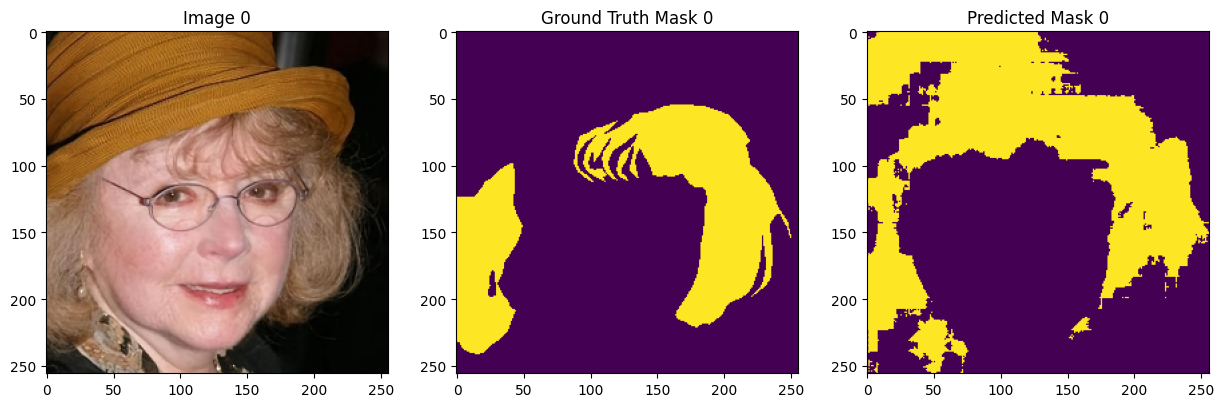

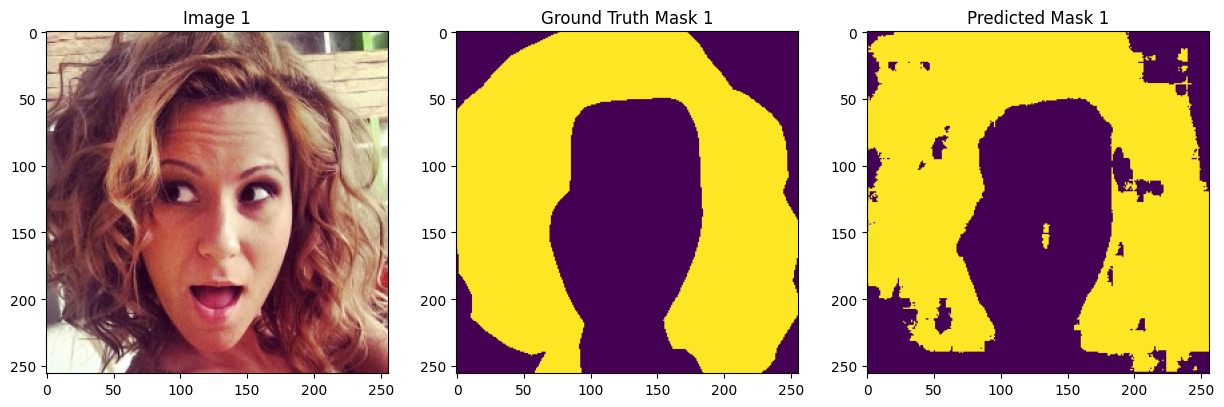

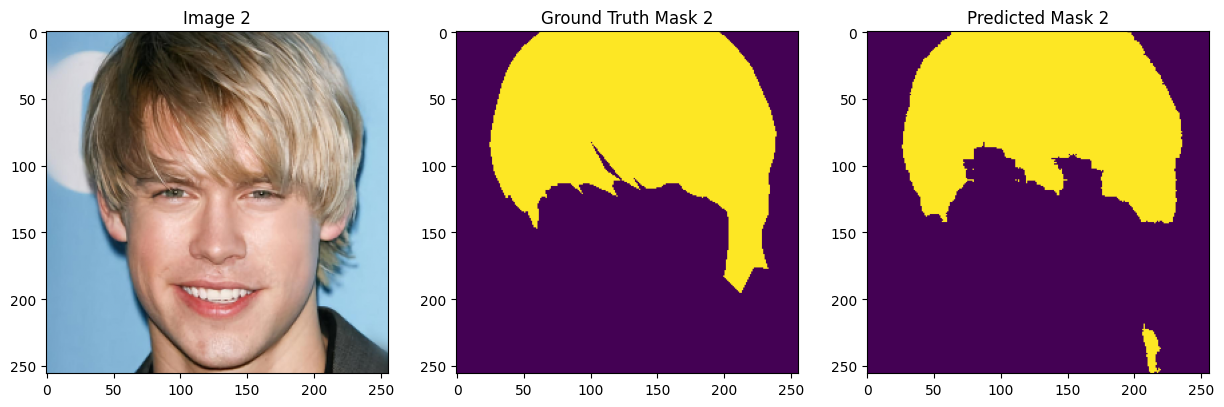

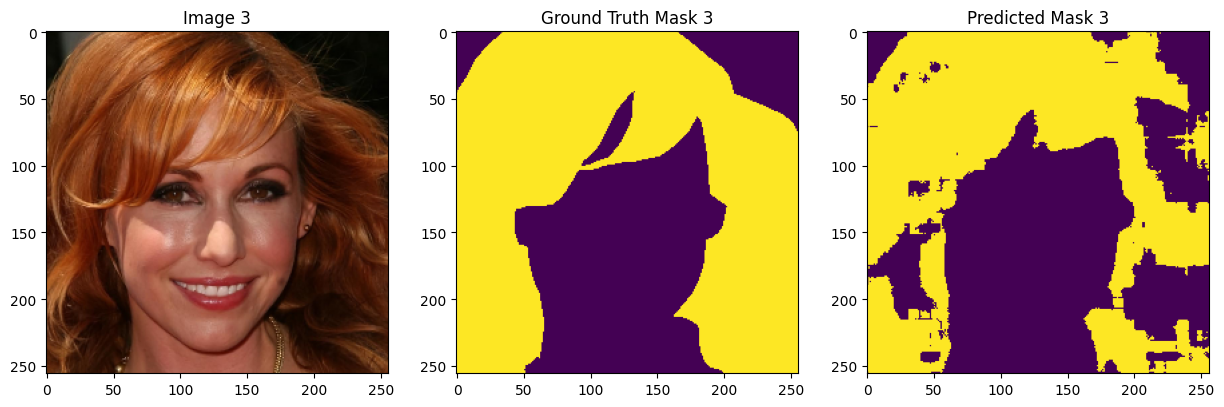

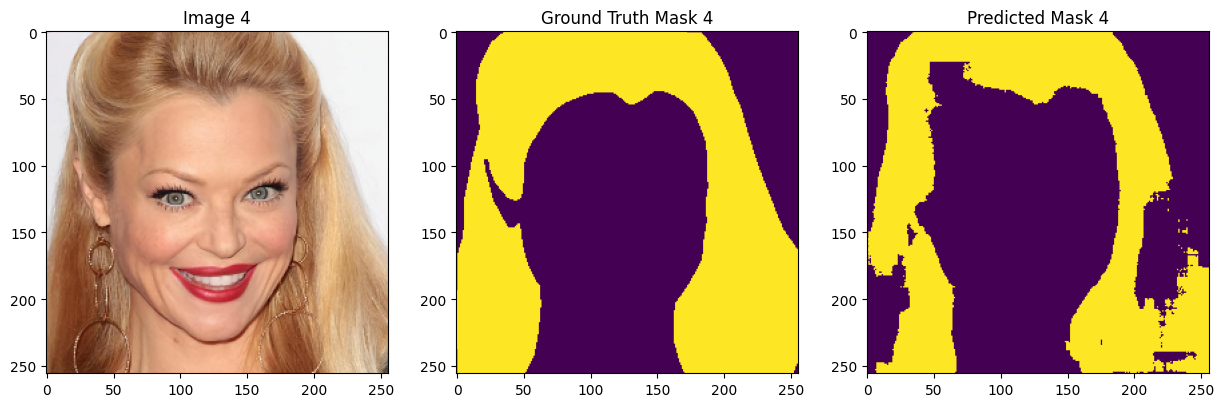

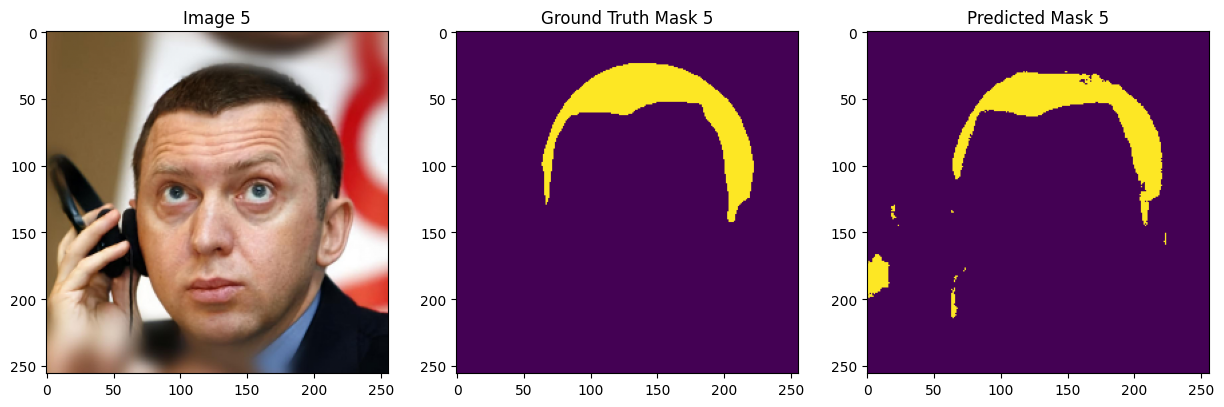

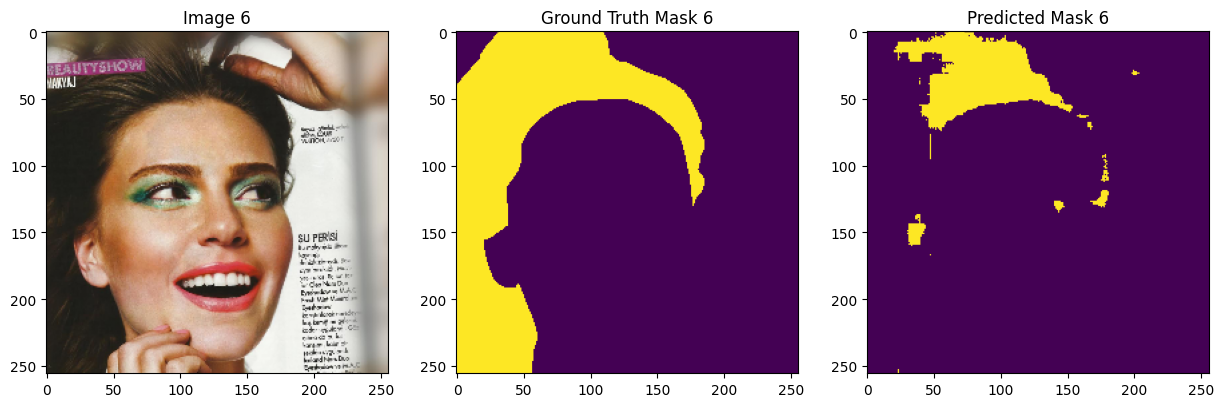

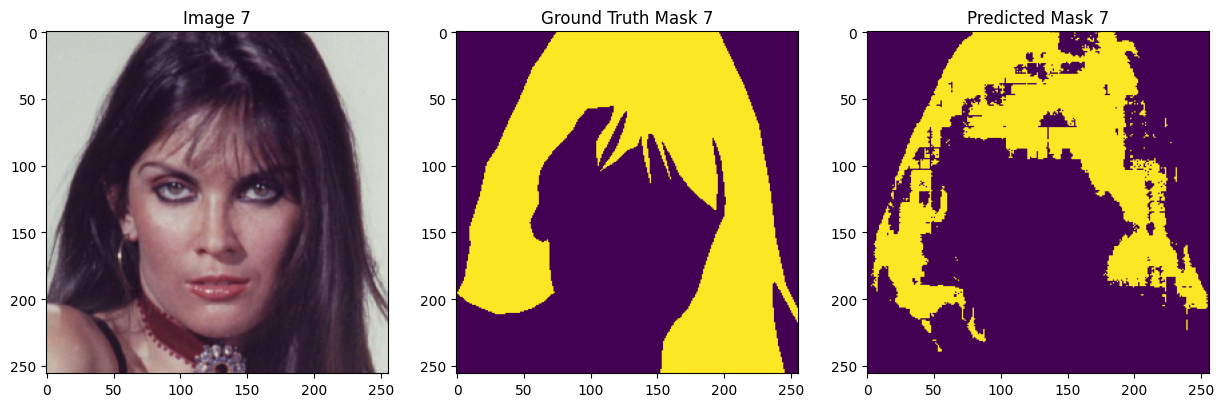

In [ ]:

for batch_images, batch_masks in test_data_generator:
  # Make predictions here using model.predict(batch_images)
  predictions = model.predict(batch_images)

  # Process predictions and masks
  for i in range(len(batch_images)):
      plt.figure(figsize=(15, 5))

      plt.subplot(1, 3, 1)
      plt.imshow(batch_images[i])
      plt.title(f"Image {i}")

      plt.subplot(1, 3, 2)
      plt.imshow(np.argmax(batch_masks[i], axis=-1)) # Display the class index
      plt.title(f"Ground Truth Mask {i}")

      plt.subplot(1, 3, 3)
      plt.imshow(np.argmax(predictions[i], axis=-1))
      plt.title(f"Predicted Mask {i}")

      plt.show()
  break #remove this when you want to process the whole test dataset


In [ ]:
test_batch_size = 16 # Set batch size for test data
test_data_generator = load_data(IMAGE_DIR, MASK_DIR, batch_size=test_batch_size,test_data=True)

In [ ]:
# prompt: How to calculate accuracy of predicted and actual masks

from sklearn.metrics import accuracy_score

# ... (Your existing code)

# Initialize lists to store flattened predictions and true masks
all_true_masks = []
all_predicted_masks = []
count=0
# Iterate and make predictions for test data
for batch_images, batch_masks in test_data_generator:
    count=count+1
    if(count>20):
      break;
    # Make predictions here using model.predict(batch_images)
    predictions = model.predict(batch_images)

    # Flatten the true masks and predictions for each image in the batch
    for i in range(len(batch_images)):
        true_mask = np.argmax(batch_masks[i], axis=-1).flatten()
        predicted_mask = np.argmax(predictions[i], axis=-1).flatten()

        all_true_masks.extend(true_mask)
        all_predicted_masks.extend(predicted_mask)

    # Stop after processing a certain number of batches (optional)
    # Remove this break if you want to evaluate the whole test set
    #break

# Calculate the overall accuracy
accuracy = accuracy_score(all_true_masks, all_predicted_masks)
print(f"Overall Accuracy: {accuracy}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Overall Accuracy: 0.9128987312316894


**Business Problem**

*   Virtual try ons for spectacles, jewellery, hats etc
*   Face editing & generation for new looks
*   Face Segmentation of analysis facial expressions can identify neurological disorders

**Dataset**

*   CelebAMask-HQ standard dataset for face segmentation
*   30K high resolution images of 512 x 512 resolution
*   19 classes

**Model Used**
U-Net Architecture with 3 encoders and 3 decoders
Encoder-Decoder architecture with skip connections makes it suitable for face segmentation

**Use Cases**
*   Virtual Try Ons
*   Face regeneration & edits


















Progress made
1) Trained on more data
2) Achieved higher accuracy

Roadblocks
1) Large dataset
2) High computational resources required to train & evaluate
3) Notebook crashed due to out of memory issues multiple times

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step


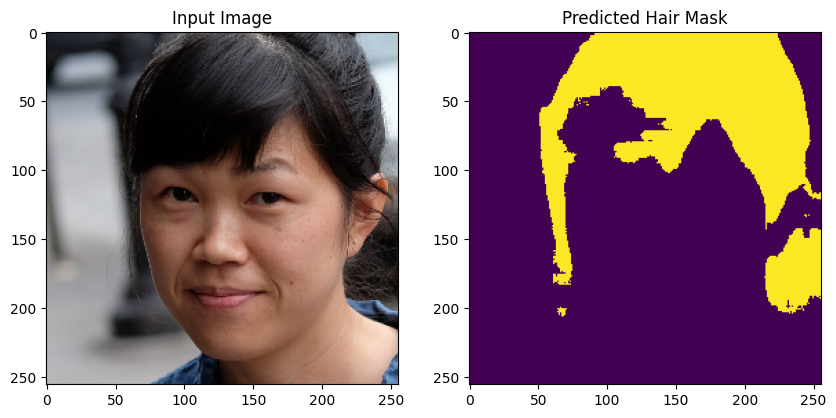

In [ ]:
## inferencing on loaded images
# Load and preprocess the input image
img_path = '/content/08032.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
img = cv2.resize(img, (256, 256))  # Resize to match model input
img = img / 255.0  # Normalize

# Run inference
prediction = model.predict(np.expand_dims(img, axis=0))[0]  # Add batch dimension

# Get predicted mask
predicted_mask = np.argmax(prediction, axis=-1)

# Display the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask)
plt.title("Predicted Hair Mask")

plt.show()

In [ ]:
## enhance image
# Import necessary libraries
import cv2
from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt

def enhance_image_quality(image_path):
    # Load image using OpenCV
    img_cv = cv2.imread(image_path)

    # Convert to RGB (OpenCV loads images in BGR format)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    plt.imshow(img_cv)
    plt.axis('off')
    plt.show()

    # Improve sharpness using a sharpening kernel
    sharpening_kernel = np.array([[0, -1, 0],
                                   [-1, 5, -1],
                                   [0, -1, 0]])
    sharpened_img = cv2.filter2D(img_cv, -1, sharpening_kernel)

    # Convert to PIL for further enhancements (optional)
    img_pil = Image.fromarray(sharpened_img)

    # Enhance sharpness further using PIL
    sharpness_enhancer = ImageEnhance.Sharpness(img_pil)
    sharpened_img = sharpness_enhancer.enhance(2.0)  # Adjust factor as needed

    # Enhance overall quality (brightness and contrast)
    contrast_enhancer = ImageEnhance.Contrast(sharpened_img)
    final_img = contrast_enhancer.enhance(1.1)  # Adjust factor as needed

    brightness_enhancer = ImageEnhance.Brightness(final_img)
    final_img = brightness_enhancer.enhance(1.1)  # Adjust factor as needed

    # Save the final enhanced image
    #final_img.save(output_path)

    # Display the enhanced image (optional)
    plt.imshow(final_img)
    plt.axis('off')
    plt.show()
    return final_img

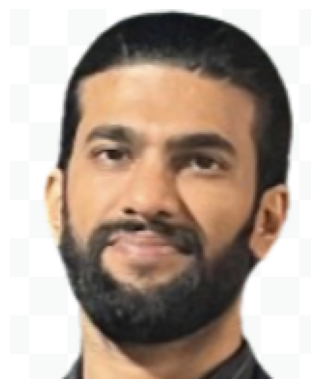

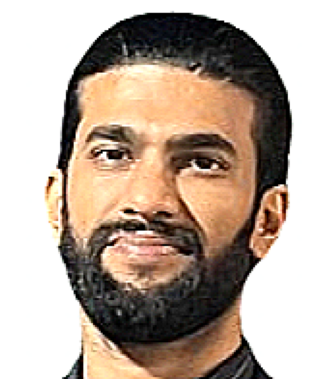

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


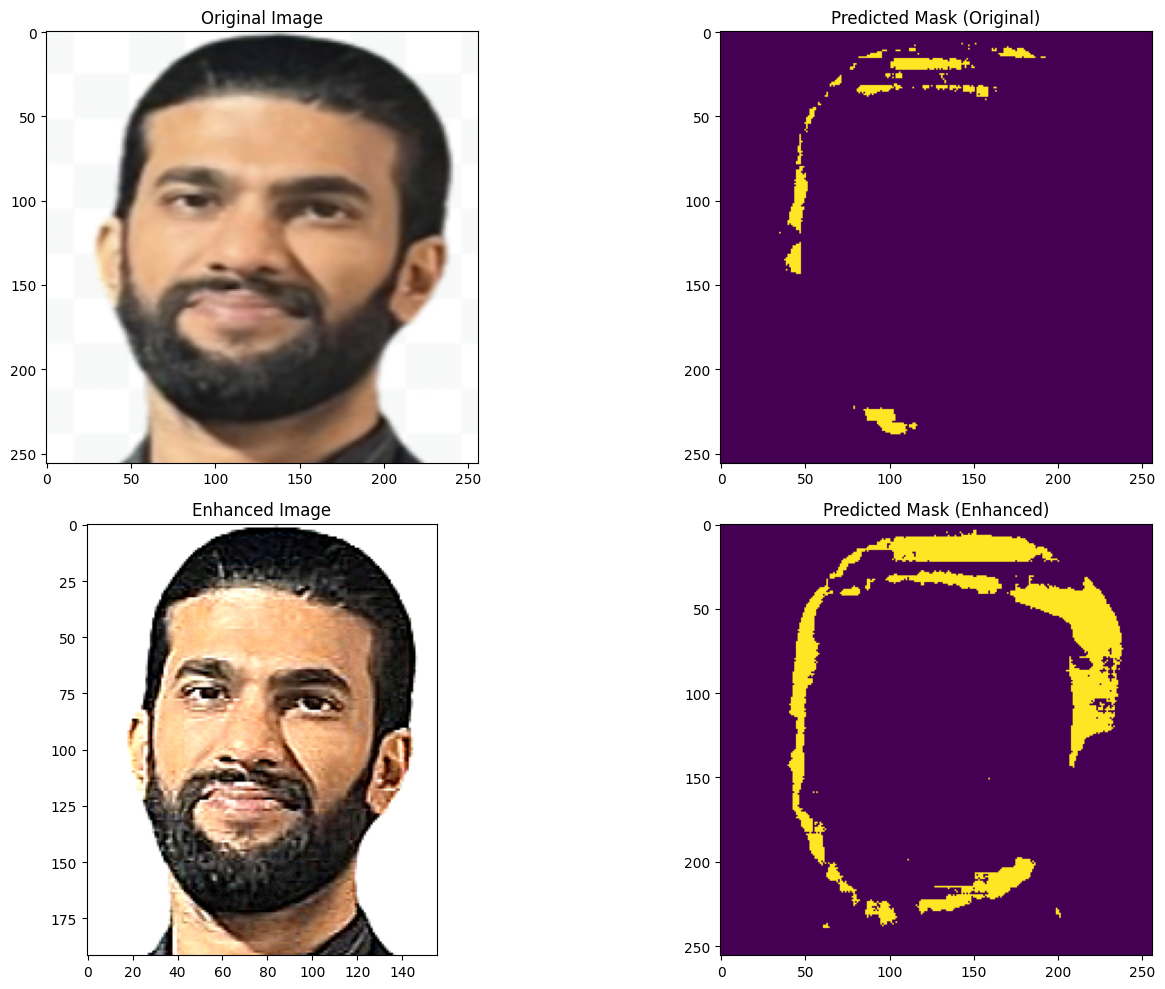

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from PIL import Image, ImageEnhance


# Load and preprocess the input image
img_path = '/content/self_face.png'

# Original Image
original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_img = cv2.resize(original_img, (256, 256))
original_img = original_img / 255.0

# Enhance image quality
enhanced_img = enhance_image_quality(img_path)

# Convert the enhanced image to a NumPy array and normalize
enhanced_img_np = np.array(enhanced_img)
enhanced_img_np = cv2.resize(enhanced_img_np, (256, 256))
enhanced_img_np = enhanced_img_np / 255.0

# Run inference on original image
prediction_original = model.predict(np.expand_dims(original_img, axis=0))[0]
predicted_mask_original = np.argmax(prediction_original, axis=-1)

# Run inference on enhanced image
prediction_enhanced = model.predict(np.expand_dims(enhanced_img_np, axis=0))[0]
predicted_mask_enhanced = np.argmax(prediction_enhanced, axis=-1)

# Display the results in a 2x2 grid
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")

plt.subplot(2, 2, 2)
plt.imshow(predicted_mask_original)
plt.title("Predicted Mask (Original)")

plt.subplot(2, 2, 3)
plt.imshow(enhanced_img)
plt.title("Enhanced Image")

plt.subplot(2, 2, 4)
plt.imshow(predicted_mask_enhanced)
plt.title("Predicted Mask (Enhanced)")

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [ ]:
# prompt: how to load model from path /content/drive/MyDrive/Computer_Vision/best_model.h5
# loading model 1 - UNet Model

model = keras.models.load_model('/content/drive/MyDrive/Computer_Vision_h5_model/best_model_20000.h5')



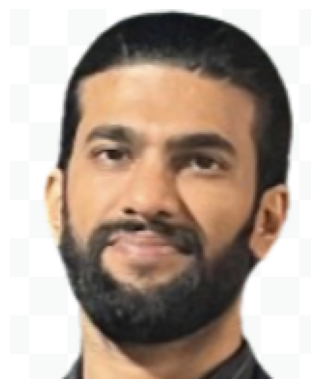

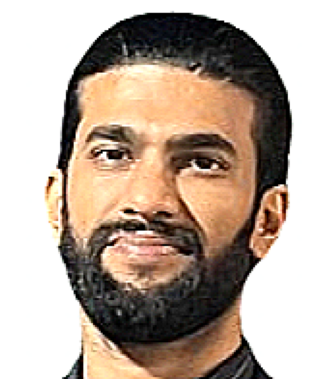

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


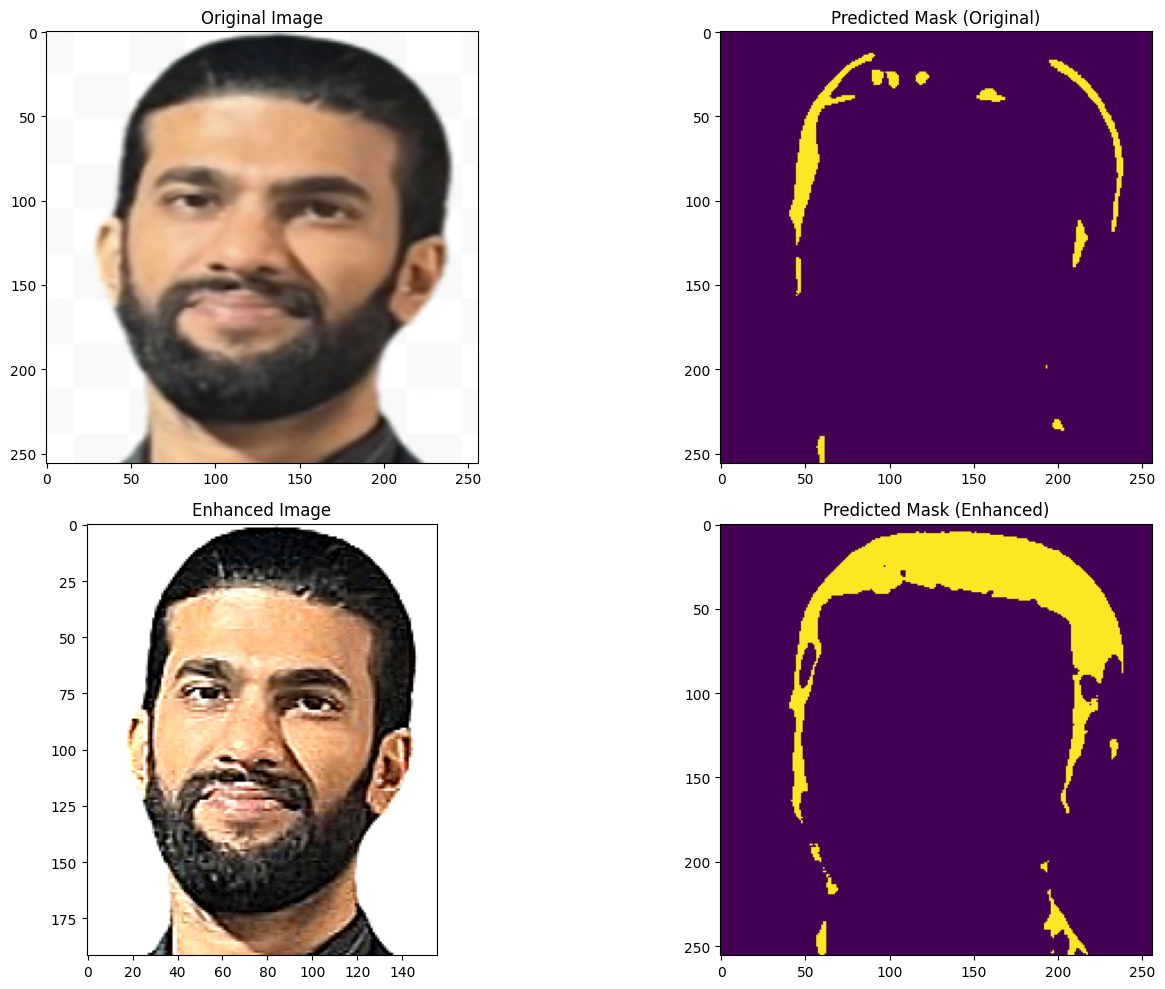

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from PIL import Image, ImageEnhance

# Load and preprocess the input image
img_path = '/content/self_face.png'

# Original Image
original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_img = cv2.resize(original_img, (256, 256))
original_img = original_img / 255.0

# Enhance image quality
enhanced_img = enhance_image_quality(img_path)

# Convert the enhanced image to a NumPy array and normalize
enhanced_img_np = np.array(enhanced_img)
enhanced_img_np = cv2.resize(enhanced_img_np, (256, 256))
enhanced_img_np = enhanced_img_np / 255.0

# Run inference on original image
prediction_original = model.predict(np.expand_dims(original_img, axis=0))[0]
predicted_mask_original = np.argmax(prediction_original, axis=-1)

# Run inference on enhanced image
prediction_enhanced = model.predict(np.expand_dims(enhanced_img_np, axis=0))[0]
predicted_mask_enhanced = np.argmax(prediction_enhanced, axis=-1)

# Display the results in a 2x2 grid
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(original_img)
plt.title("Original Image")

plt.subplot(2, 2, 2)
plt.imshow(predicted_mask_original)
plt.title("Predicted Mask (Original)")

plt.subplot(2, 2, 3)
plt.imshow(enhanced_img)
plt.title("Enhanced Image")

plt.subplot(2, 2, 4)
plt.imshow(predicted_mask_enhanced)
plt.title("Predicted Mask (Enhanced)")

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


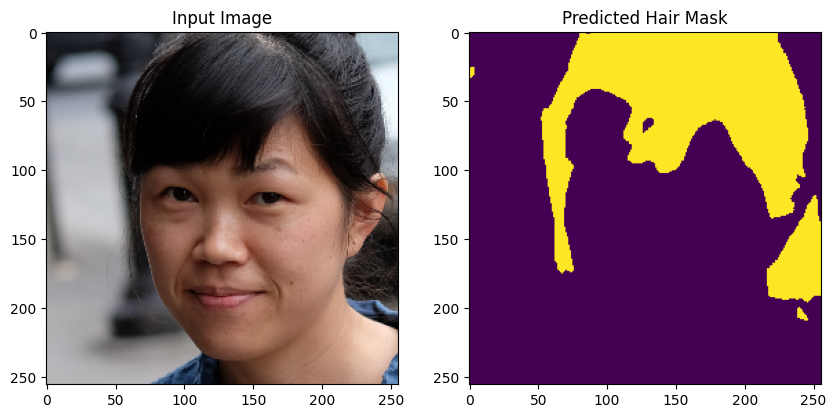

In [ ]:
## inferencing on loaded images
# Load and preprocess the input image
img_path = '/content/08032.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
img = cv2.resize(img, (256, 256))  # Resize to match model input
img = img / 255.0  # Normalize

# Run inference
prediction = model.predict(np.expand_dims(img, axis=0))[0]  # Add batch dimension

# Get predicted mask
predicted_mask = np.argmax(prediction, axis=-1)

# Display the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask)
plt.title("Predicted Hair Mask")

plt.show()